- [1. Importación de datasets](#import)
- [2. Exploración y análisis de datos](#eda)
  * [2.1. Exploración](#explor)
  * [2.2. Datos no disponibles (missing data)](#missing-data)
  * [2.3. Conversión de variables categóricas a numérica](#categ-to-num)
  * [2.4. Análisis de valores atípicos](#outliers)
  * [2.5. Análisis de correlación](#corr)
- [3. Selección de características (VIF: Factor de Inflación de la Varianza)](#vif)
- [4. Creación de modelos de Machine Learning](#ml)
  * [4.1. Modelo para la variable `Dysthymia`](#ml-dyst)
    + [4.1.1. Selección de modelo](#ml-dyst-select)
    + [4.1.2. Optimización de hiperparámetros](#ml-dyst-hyper)
    + [4.1.3. Visualización de modelo](#ml-dyst-viz)
  * [4.2. Modelo para la variable `Major Depressive Disorder`](#ml-depr)
    + [4.2.1. Selección de modelo](#ml-depr-select)
    + [4.2.2. Optimización de hiperparámetros](#ml-depr-hyper)
    + [4.2.3. Visualización de modelo](#ml-depr-viz)
  * [4.3. Modelo para la variable `Anxiety Disorders`](#ml-anxi)
    + [4.3.1. Selección de modelo](#ml-anxi-select)
    + [4.3.2. Optimización de hiperparámetros](#ml-anxi-hyper)
    + [4.3.3. Visualización de modelo](#ml-anxi-viz)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
pd.set_option('display.max_columns', None)

## <a id="import">1. Importación de datasets</a>

Leemos los datos del dataset en Excel. Eliminaremos las variables absolutas, ya que sus valores relativos (en base al número de habitantes) ya han sido calculados y están presentes en el dataset. También retiraremos las variables de datos de población empleadas para estos cálculos:

In [2]:
xls = pd.ExcelFile("Dataset_final.xlsx")
df = pd.read_excel(xls, 'Final')

# Remove absolute values for those columns with relative values already
df.drop(columns = ['Anxiety disorders','Cardiovascular diseases',
    'Chronic respiratory diseases','Diabetes and kidney diseases',
    'Neoplasms', 'Stroke', 'Dysthymia', 'Major depressive disorder', 
    'Material deprivation'], inplace = True)

# Remove population data used to calculate percentages from absolute values
df.drop(columns = ['Total Population (male/female)', '% of population', 'Population'], inplace = True)

# Remove ISO Codes
df.drop(columns = 'ISO Code', inplace = True)

# Setting shorter names for better handling and display:
df.rename(columns={ 'Anxiety disorders (%)':'Anxiety disorders',
                    'Cardiovascular diseases (%)':'Cardiovascular diseases',
                    'Chronic respiratory diseases (%)':'Chronic respiratory diseases',
                    'Diabetes and kidney diseases (%)':'Diabetes and kidney diseases',
                    'Dysthymia (%)':'Dysthymia',
                    'Major depressive disorder (%)':'Major depressive disorder',
                    'Neoplasms (%)':'Neoplasms',
                    'Stroke (%)': 'Stroke',
                    'Material deprivation (%)' : 'Material deprivation'}, inplace = True)

df.head()

Year Location    Age     Sex  Anxiety disorders  Cardiovascular diseases  \
0  2000  Austria  10-14  Female           1.918927                 0.018866   
1  2000  Austria  10-14    Male           1.155497                 0.021858   
2  2000  Austria  15-19  Female           1.390330                 0.031175   
3  2000  Austria  15-19    Male           0.862132                 0.039644   
4  2000  Austria  20-24  Female           1.114877                 0.057503   

   Chronic respiratory diseases  Diabetes and kidney diseases  Dysthymia  \
0                      0.870762                      0.034035   0.170342   
1                      0.790257                      0.036608   0.098739   
2                      0.688713                      0.062370   0.276909   
3                      0.500221                      0.053740   0.183152   
4                      0.471239                      0.074827   0.286051   

   Major depressive disorder  Neoplasms    Stroke Unemployment  \
0                   2.971534   3.030821  0.011687          NaN   
1                   1.438349   2.704850  0.008670          NaN   
2                   5.419027   5.741317  0.011084          2.7   
3                   2.839262   3.945555  0.008828            3   
4                   5.776370   6.870868  0.013937          2.7   

   Material deprivation Median income  Hours worked per week  Overweight  \
0                   NaN           NaN                    NaN         NaN   
1                   NaN           NaN                    NaN         NaN   
2                   NaN         14917                    NaN         NaN   
3                   NaN         15659                    NaN         NaN   
4                   NaN         14917                    NaN         NaN   

   Underweight At-risk-of poverty rate Physical Activity (Aerobic)  \
0          NaN                                                 NaN   
1          NaN                                                 NaN   
2          NaN                                                 NaN   
3          NaN                                                 NaN   
4          NaN                                                 NaN   

   Physical Activity (Muscular)  Employment discrimination  Ecstasy use  \
0                           NaN                        NaN          NaN   
1                           NaN                        NaN          NaN   
2                           NaN                        NaN          NaN   
3                           NaN                        NaN          NaN   
4                           NaN                        NaN          NaN   

   Cocaine use  Amphetamines use  Cannabis use  LSD use  CO2 emissions  \
0          NaN               NaN           NaN      NaN        63530.0   
1          NaN               NaN           NaN      NaN        63530.0   
2          NaN               NaN           NaN      NaN        63530.0   
3          NaN               NaN           NaN      NaN        63530.0   
4          NaN               NaN           NaN      NaN        63530.0   

   HFC gas emissions  Methane emissions  Nitrous oxide emissions  \
0             1018.4             8940.0                   4590.0   
1             1018.4             8940.0                   4590.0   
2             1018.4             8940.0                   4590.0   
3             1018.4             8940.0                   4590.0   
4             1018.4             8940.0                   4590.0   

   Compulsory education duration  Gini index  \
0                            9.0        28.8   
1                            9.0        28.8   
2                            9.0        28.8   
3                            9.0        28.8   
4                            9.0        28.8   

   Government expenditure on education  Tobacco use  Alcohol consumption  \
0                              5.58881          NaN                 6.37   
1                              5.58881          Na

Mostramos los tipos de datos, por si hubiese que forzar el cambio de tipo sobre alguna columna:

In [3]:
print(df.shape)
print(df.dtypes)

(17280, 43)
Year                                                   int64
Location                                              object
Age                                                   object
Sex                                                   object
Anxiety disorders                                    float64
Cardiovascular diseases                              float64
Chronic respiratory diseases                         float64
Diabetes and kidney diseases                         float64
Dysthymia                                            float64
Major depressive disorder                            float64
Neoplasms                                            float64
Stroke                                               float64
Unemployment                                          object
Material deprivation                                 float64
Median income                                         object
Hours worked per week                                float64
Overweight  

Efectivamente, algunas variables numéricas no han adoptado el tipo de datos deseado, por lo que forzamos con el método to_numeric sobre todo el dataset, exceptuando las variables de país, edad y sexo:

In [4]:
cols = df.columns.drop(['Location','Age','Sex'])
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df['Year'] = pd.to_datetime(df['Year'], format = '%Y')
print(df.dtypes)

Year                                                 datetime64[ns]
Location                                                     object
Age                                                          object
Sex                                                          object
Anxiety disorders                                           float64
Cardiovascular diseases                                     float64
Chronic respiratory diseases                                float64
Diabetes and kidney diseases                                float64
Dysthymia                                                   float64
Major depressive disorder                                   float64
Neoplasms                                                   float64
Stroke                                                      float64
Unemployment                                                float64
Material deprivation                                        float64
Median income                                   

## <a id="eda">2. Exploración y limpieza de datos</a>

### <a id="explor">2.1. Exploración</a>

Exporto a Excel el dataframe, de cara a trabajar en su visualización en Tableau, externamente:

In [5]:
df.to_excel('dataframe_incomplete.xlsx')

Muestro el dataset en Tableau embebido con HTML:

<span style="color:red">(Observación: Para algunas variables, varias o todas las franjas de edad comparten el mismo dato, por lo que se solapan las líneas mostrando un único color. Se trata de un punto a mejorar en la visualización de datos)</span>

(No visible en Gitlab, es necesario ejecutar notebook en otro medio. Accesible también [aquí](https://public.tableau.com/app/profile/emilio.molina/viz/Datav_16404525264210/Dashboard-Incomplete).)

In [6]:
%%html
<div class='tableauPlaceholder' id='viz1640461550321' style='position: relative'>
    <object class='tableauViz'  style='display:none;'>
        <param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> 
        <param name='embed_code_version' value='3' /> 
        <param name='site_root' value='' />
        <param name='name' value='Datav_16404525264210&#47;Dashboard1' />
        <param name='tabs' value='no' />
        <param name='toolbar' value='yes' />
        <param name='animate_transition' value='yes' />
        <param name='display_static_image' value='yes' />
        <param name='display_spinner' value='yes' />
        <param name='display_overlay' value='yes' />
        <param name='display_count' value='yes' />
        <param name='language' value='es-ES' />
    </object>
</div>                
<script type='text/javascript'>
    var divElement = document.getElementById('viz1640461550321');
    var vizElement = divElement.getElementsByTagName('object')[0];
    if ( divElement.offsetWidth > 800 ) { 
        vizElement.style.width='1000px';
        vizElement.style.height='827px';
    } else if ( divElement.offsetWidth > 500 ) { 
        vizElement.style.width='1000px';
        vizElement.style.height='827px';
    } else { 
        vizElement.style.width='100%';
        vizElement.style.height='727px';
    }                     
    var scriptElement = document.createElement('script');                    
    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    
    vizElement.parentNode.insertBefore(scriptElement, vizElement);                
</script>

### <a id="missing-data">2.2. Datos no disponibles (*missing data*)</a>

Como podemos observar, para algunas series temporales faltan datos de algunos años (por ejemplo, en el consumo de alcohol en cualquier país):

Con un mapa de color podemos rápidamente ver que existen huecos en los datos, por alguno de los siguientes motivos:
- No existen datos para esa serie durante algunos años.
- No existen datos para esa serie en alguno de los países.
- Algunas variables no son relevantes para ciertas franjas de edad (ejemplo: horas semanales de trabajo en menores de 16 años)

Para aplicar técnicas de aprendizaje automático de una manera efectiva, las series temporales han de ser continuas. Por lo tanto, es necesario rellenar con el valor adecuado. 

De estos supuestos, solucionaremos el primero más adelante.

<AxesSubplot:>

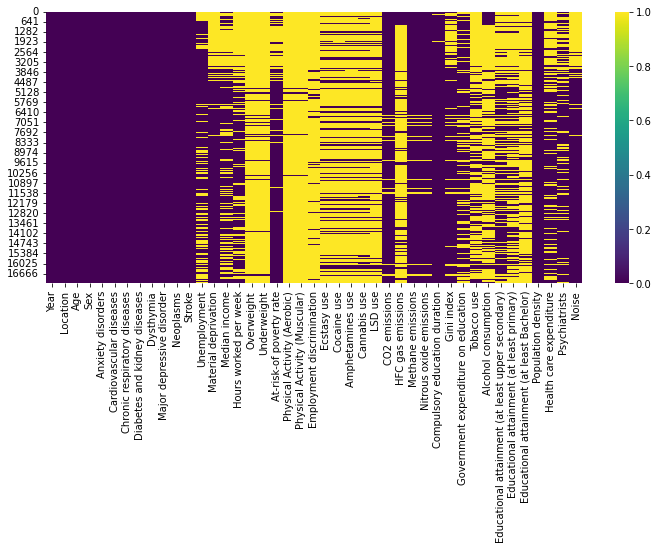

In [7]:
cols = df.columns
fig, ax = plt.subplots(figsize=(12,5)) 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette("viridis", as_cmap=True), ax = ax) #yellow is missing value

También podemos ver el porcentaje de líneas completas para cada una de las variables:

In [8]:
for col in df.columns:
    perc_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(perc_missing*100)))

Year - 0%
Location - 0%
Age - 0%
Sex - 0%
Anxiety disorders - 0%
Cardiovascular diseases - 0%
Chronic respiratory diseases - 0%
Diabetes and kidney diseases - 0%
Dysthymia - 0%
Major depressive disorder - 0%
Neoplasms - 0%
Stroke - 0%
Unemployment - 28%
Material deprivation - 23%
Median income - 41%
Hours worked per week - 45%
Overweight - 92%
Underweight - 92%
At-risk-of poverty rate - 22%
Physical Activity (Aerobic) - 97%
Physical Activity (Muscular) - 97%
Employment discrimination - 91%
Ecstasy use - 76%
Cocaine use - 76%
Amphetamines use - 76%
Cannabis use - 72%
LSD use - 79%
CO2 emissions - 5%
HFC gas emissions - 80%
Methane emissions - 5%
Nitrous oxide emissions - 5%
Compulsory education duration - 1%
Gini index - 22%
Government expenditure on education - 25%
Tobacco use - 70%
Alcohol consumption - 75%
Educational attainment (at least upper secondary) - 42%
Educational attainment (at least primary) - 56%
Educational attainment (at least Bachelor) - 78%
Population density - 0%
Hea

El dataset es la combinación de datos de 39 variables a lo largo de 20 años para 27 países, 16 franjas de edad y 2 sexos.

Para las labores de limpieza de series temporales desagregaremos los datos por país (27), edad (16) y sexo (2), trabajando así con 864 líneas temporales diferentes:

In [9]:
df_sliced = []
for country in df['Location'].unique():
    for age in df['Age'].unique():
        for sex in df['Sex'].unique():
            df_sliced.append(df[df['Location']==country][df['Age']==age][df['Sex']==sex].sort_values(by="Year").reset_index(drop=True))
len(df_sliced)

/tmp/ipykernel_8528/2728028312.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sliced.append(df[df['Location']==country][df['Age']==age][df['Sex']==sex].sort_values(by="Year").reset_index(drop=True))


864

Pondremos como ejemplo la primera:

In [10]:
df_sliced[0].head(10)

Year Location    Age     Sex  Anxiety disorders  \
0 2000-01-01  Austria  10-14  Female           1.918927   
1 2001-01-01  Austria  10-14  Female           1.930495   
2 2002-01-01  Austria  10-14  Female           1.948027   
3 2003-01-01  Austria  10-14  Female           1.958325   
4 2004-01-01  Austria  10-14  Female           1.960655   
5 2005-01-01  Austria  10-14  Female           1.959440   
6 2006-01-01  Austria  10-14  Female           1.959454   
7 2007-01-01  Austria  10-14  Female           1.972949   
8 2008-01-01  Austria  10-14  Female           1.980244   
9 2009-01-01  Austria  10-14  Female           1.989012   

   Cardiovascular diseases  Chronic respiratory diseases  \
0                 0.018866                      0.870762   
1                 0.018868                      0.876385   
2                 0.018831                      0.882417   
3                 0.018688                      0.883708   
4                 0.018497                      0.880787   
5                 0.018356                      0.876461   
6                 0.018324                      0.871374   
7                 0.018471                      0.869717   
8                 0.018588                      0.863902   
9                 0.018720                      0.858497   

   Diabetes and kidney diseases  Dysthymia  Major depressive disorder  \
0                      0.034035   0.170342                   2.971534   
1                      0.034649   0.170799                   2.973789   
2                      0.035265   0.171048                   2.965187   
3                      0.035718   0.170355                   2.935302   
4                      0.036066   0.169091                   2.892999   
5                      0.036465   0.168044                   2.854112   
6                      0.036973   0.167536                   2.813057   
7                      0.037734   0.168245                   2.776909   
8                      0.038369   0.168459                   2.729556   
9                      0.039012   0.168805                   2.694154   

   Neoplasms    Stroke  Unemployment  Material deprivation  Median income  \
0   3.030821  0.011687           NaN                   NaN            NaN   
1   3.063221  0.011659           NaN                   NaN            NaN   
2   3.092051  0.011588           NaN                   NaN            NaN   
3   3.102900  0.011440           NaN              0.002557            NaN   
4   3.098988  0.011261           NaN              0.002954            NaN   
5   3.096226  0.011119           NaN              0.004216            NaN   
6   3.106376  0.011029           NaN              0.005953            NaN   
7   3.142027  0.011017           NaN              0.006069            NaN   
8   3.167444  0.010976           NaN              0.003560            NaN   
9   3.192097  0.010952           NaN              0.005492            NaN   

   Hours worked per week  Overweight  Underweight  At-risk-of poverty rate  \
0                    NaN         NaN          NaN                      NaN   
1                    NaN         NaN          NaN                      NaN   
2                    NaN         NaN          NaN                      NaN   
3                    NaN         NaN          NaN                     14.2   
4                    NaN         NaN          NaN                     15.9   
5                    NaN         NaN          NaN                     15.1   
6                    NaN         NaN          NaN                     14.9   
7                    NaN         NaN          NaN                     14.3   
8                    NaN         NaN          NaN                     18.0   
9                   43.8         NaN          NaN                     17.3   

   Physical Activity (Aerobic)  Physical Activity (Muscular)  \
0                          NaN                           NaN   
1                          NaN                           N

Normalmente, en series no temporales se rellenan los huecos con la media o mediana. No obstante, esto no es aplicable en series temporales ya que produciría saltos abruptos en la serie.

In [11]:
df_tst = df_sliced[0].set_index('Year').interpolate(method = 'linear', axis = 0).ffill().bfill() 
df_tst.head()

Location    Age     Sex  Anxiety disorders  \
Year                                                    
2000-01-01  Austria  10-14  Female           1.918927   
2001-01-01  Austria  10-14  Female           1.930495   
2002-01-01  Austria  10-14  Female           1.948027   
2003-01-01  Austria  10-14  Female           1.958325   
2004-01-01  Austria  10-14  Female           1.960655   

            Cardiovascular diseases  Chronic respiratory diseases  \
Year                                                                
2000-01-01                 0.018866                      0.870762   
2001-01-01                 0.018868                      0.876385   
2002-01-01                 0.018831                      0.882417   
2003-01-01                 0.018688                      0.883708   
2004-01-01                 0.018497                      0.880787   

            Diabetes and kidney diseases  Dysthymia  \
Year                                                  
2000-01-01                      0.034035   0.170342   
2001-01-01                      0.034649   0.170799   
2002-01-01                      0.035265   0.171048   
2003-01-01                      0.035718   0.170355   
2004-01-01                      0.036066   0.169091   

            Major depressive disorder  Neoplasms    Stroke  Unemployment  \
Year                                                                       
2000-01-01                   2.971534   3.030821  0.011687           NaN   
2001-01-01                   2.973789   3.063221  0.011659           NaN   
2002-01-01                   2.965187   3.092051  0.011588           NaN   
2003-01-01                   2.935302   3.102900  0.011440           NaN   
2004-01-01                   2.892999   3.098988  0.011261           NaN   

            Material deprivation  Median income  Hours worked per week  \
Year                                                                     
2000-01-01              0.002557            NaN                   43.8   
2001-01-01              0.002557            NaN                   43.8   
2002-01-01              0.002557            NaN                   43.8   
2003-01-01              0.002557            NaN                   43.8   
2004-01-01              0.002954            NaN                   43.8   

            Overweight  Underweight  At-risk-of poverty rate  \
Year                                                           
2000-01-01         NaN          NaN                     14.2   
2001-01-01         NaN          NaN                     14.2   
2002-01-01         NaN          NaN                     14.2   
2003-01-01         NaN          NaN                     14.2   
2004-01-01         NaN          NaN                     15.9   

            Physical Activity (Aerobic)  Physical Activity (Muscular)  \
Year                                                                    
2000-01-01                          NaN                           NaN   
2001-01-01                          NaN                           NaN   
2002-01-01                          NaN                           NaN   
2003-01-01                          NaN                           NaN   
2004-01-01                          NaN                           NaN   

            Employment discrimination  Ecstasy use  Cocaine use  \
Year                                                              
2000-01-01                        NaN          3.0          2.3   
2001-01-01                        NaN          3.0          2.3   
2002-01-01                        NaN          3.0          2.3   
2003-01-01                        NaN          3.0          2.3   
2004-01-01                        NaN          3.0          2.3   

            Amphetamines use  Cannabis use  LSD use  CO2 emissions  \
Year                                                                 
2000-01-01               2.4          20.1      1.7        63530.0   
2001-01-01               2.4          20.1      

Aplicamos ahora el mismo concepto al conjunto de líneas temporales, volviendo a agruparlas al finalizar:

In [12]:
df_filled_lst = []
for ts in df_sliced:
    ts_copy = ts.copy()
    ts_copy = ts_copy.set_index('Year').interpolate(method = 'linear', axis = 0).ffill().bfill()
    # (setting temporarily Year as index to avoid error with datetime64ns type)
    df_filled_lst.append(ts_copy)
    
df_filled = pd.concat(df_filled_lst).reset_index()
df_filled

Year Location    Age     Sex  Anxiety disorders  \
0     2000-01-01  Austria  10-14  Female           1.918927   
1     2001-01-01  Austria  10-14  Female           1.930495   
2     2002-01-01  Austria  10-14  Female           1.948027   
3     2003-01-01  Austria  10-14  Female           1.958325   
4     2004-01-01  Austria  10-14  Female           1.960655   
...          ...      ...    ...     ...                ...   
17275 2015-01-01   Sweden    +80    Male           0.186070   
17276 2016-01-01   Sweden    +80    Male           0.184695   
17277 2017-01-01   Sweden    +80    Male           0.185061   
17278 2018-01-01   Sweden    +80    Male           0.186947   
17279 2019-01-01   Sweden    +80    Male           0.189314   

       Cardiovascular diseases  Chronic respiratory diseases  \
0                     0.018866                      0.870762   
1                     0.018868                      0.876385   
2                     0.018831                      0.882417   
3                     0.018688                      0.883708   
4                     0.018497                      0.880787   
...                        ...                           ...   
17275                 6.411849                      2.959630   
17276                 6.152614                      2.877913   
17277                 5.976275                      2.819210   
17278                 5.986550                      2.840986   
17279                 6.070587                      2.895308   

       Diabetes and kidney diseases  Dysthymia  Major depressive disorder  \
0                          0.034035   0.170342                   2.971534   
1                          0.034649   0.170799                   2.973789   
2                          0.035265   0.171048                   2.965187   
3                          0.035718   0.170355                   2.935302   
4                          0.036066   0.169091                   2.892999   
...                             ...        ...                        ...   
17275                      1.984041   0.158534                   3.733821   
17276                      1.967581   0.156603                   3.710194   
17277                      1.970578   0.155935                   3.719170   
17278                      1.985633   0.156687                   3.744957   
17279                      2.008368   0.157875                   3.770850   

       Neoplasms    Stroke  Unemployment  Material deprivation  Median income  \
0       3.030821  0.011687           NaN              0.002557            NaN   
1       3.063221  0.011659           NaN              0.002557            NaN   
2       3.092051  0.011588           NaN              0.002557            NaN   
3       3.102900  0.011440           NaN              0.002557            NaN   
4       3.098988  0.011261           NaN              0.002954            NaN   
...          ...       ...           ...                   ...            ...   
17275  18.098323  1.194826           NaN              0.001043        20010.0   
17276  17.893043  1.164681           NaN              0.000000        19372.0   
17277  17.883712  1.141591           NaN              0.001477        19539.0   
17278  18.064815  1.127911           NaN              0.000000        20031.0   
17279  18.409283  1.116092           NaN              0.000469        19313.0   

       Hours worked per week  Overweight  Underweight  \
0                       43.8         NaN          NaN   
1                       43.8         NaN          NaN   
2                       43.8         NaN          NaN   
3                       43.8         NaN          NaN   
4                       43.8         NaN          NaN   
...                      ...         ...          ...   
17275                   40.7        50.2          2.3   
17276                   40.7        51.4          2.1   
17277                   40.7        52.6          1.9   
17278             

Volvemos a dibujar un mapa de color para comprobar que los datos faltantes son ahora muchos menos, más relacionados con la falta de datos para algunos países y la irrelevancia de la variable para determinados grupos de edad.

<AxesSubplot:>

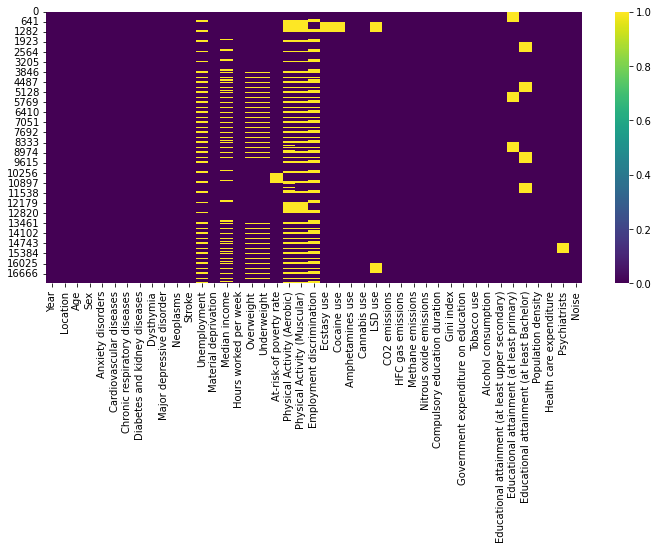

In [13]:
cols = df_filled.columns
fig, ax = plt.subplots(figsize=(12,5)) 
sns.heatmap(df_filled[cols].isnull(), cmap=sns.color_palette("viridis", as_cmap=True), ax = ax) #yellow is missing value

Volvemos a exportar el dataset, tras completar los datos faltantes, y volvemos a utilizar Tableau para representarlos:

(No visible en Gitlab, es necesario ejecutar notebook en otro medio. Accesible también [aquí](https://public.tableau.com/views/Complete_16405184997440/Dashboard-Complete?:language=es-ES&:display_count=n&:origin=viz_share_link).)

In [14]:
df_filled.to_excel('dataframe_complete.xlsx')

In [15]:
%%HTML
<div class='tableauPlaceholder' id='viz1640518697386' style='position: relative'>
    <object class='tableauViz'  style='display:none;'>
        <param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' />
        <param name='embed_code_version' value='3' />
        <param name='site_root' value='' />
        <param name='name' value='Complete_16405184997440&#47;Dashboard-Complete' />
        <param name='tabs' value='no' />
        <param name='toolbar' value='yes' />
        <param name='animate_transition' value='yes' />
        <param name='display_static_image' value='yes' />
        <param name='display_spinner' value='yes' />
        <param name='display_overlay' value='yes' />
        <param name='display_count' value='yes' />
        <param name='language' value='es-ES' />
        <param name='filter' value='publish=yes' />
    </object>
</div>
<script type='text/javascript'>                    
    var divElement = document.getElementById('viz1640518697386');                    
    var vizElement = divElement.getElementsByTagName('object')[0];                    
    if ( divElement.offsetWidth > 800 ) { 
        vizElement.style.width='800px';
        vizElement.style.height='627px';
    } else if ( divElement.offsetWidth > 500 ) { 
        vizElement.style.width='800px';vizElement.style.height='627px';
    } else { 
        vizElement.style.width='100%';vizElement.style.height='727px';
    }                     
    var scriptElement = document.createElement('script');                    
    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    
    vizElement.parentNode.insertBefore(scriptElement, vizElement);                
</script>

Si volvemos a seleccionar la variable de consumo de alcohol, por ejemplo, vemos que ahora es una línea continua en la que los datos intermedios que faltaban han sido interpolados.

### <a id="categ-to-num">2.3. Conversión de variables categóricas a numéricas</a>

Para elaborar el modelo de aprendizaje automática necesitaremos convertir a valores numéricos aquellas variables categóricas. En nuestro caso hemos de codificar `Sex` y `Age` (la edad se presenta en rangos). Para la primera, haremos uso del método `LabelEncoder` de sklearn, que asignará 0 ó 1 en función de si el sexo es masculino o femenino. En el caso de la edad, asignaremos el valor intermedio de cada rango:

In [16]:
from sklearn.preprocessing import LabelEncoder

tonumber = LabelEncoder()
df_filled['Sex'] = tonumber.fit_transform(df_filled['Sex'].astype('str'))

In [17]:
df_filled.replace({'05-09': 7, '10-14': 12, '15-19': 17, '20-24': 22, '25-29': 27, '30-34': 32, 
                    '35-39': 37, '40-44': 42, '45-49': 47, '50-54': 52, '55-59': 57, '60-64': 62, 
                    '65-69': 67, '70-74': 72, '75-79': 77, '+80': 80}, inplace = True)


In [18]:
df_filled.describe().round(2)

Age      Sex  Anxiety disorders  Cardiovascular diseases  \
count  17280.00  17280.0           17280.00                 17280.00   
mean      44.38      0.5               0.66                     1.55   
std       22.85      0.5               0.35                     2.06   
min        7.00      0.0               0.11                     0.01   
25%       25.75      0.0               0.44                     0.06   
50%       44.50      0.5               0.63                     0.46   
75%       63.25      1.0               0.79                     2.75   
max       80.00      1.0               2.64                    13.62   

       Chronic respiratory diseases  Diabetes and kidney diseases  Dysthymia  \
count                      17280.00                      17280.00   17280.00   
mean                           1.11                          0.87       0.20   
std                            0.80                          0.93       0.07   
min                            0.15                          0.02       0.02   
25%                            0.53                          0.13       0.16   
50%                            0.81                          0.48       0.20   
75%                            1.52                          1.40       0.24   
max                            4.73                          5.22       0.35   

       Major depressive disorder  Neoplasms    Stroke  Unemployment  \
count                   17280.00   17280.00  17280.00      12960.00   
mean                        4.69       9.11      0.27          5.26   
std                         2.78       6.02      0.42          3.85   
min                         0.04       0.62      0.01          0.10   
25%                         2.68       3.75      0.01          2.30   
50%                         4.15       8.26      0.07          4.60   
75%                         6.55      13.93      0.33          7.00   
max                        17.54      28.06      3.03         22.90   

       Material deprivation  Median income  Hours worked per week  Overweight  \
count              17280.00       13920.00               17280.00    15120.00   
mean                   0.03       12763.56                  41.24       51.83   
std                    0.04        8256.21                   1.08       19.19   
min                    0.00         986.00                  38.40        4.40   
25%                    0.01        5622.25                  40.70       38.70   
50%                    0.02       11650.50                  41.10       55.80   
75%                    0.04       18509.00                  41.82       67.60   
max                    0.34       44714.00                  44.60       83.60   

       Underweight  At-risk-of poverty rate  Physical Activity (Aerobic)  \
count     15120.00                 16720.00                     11640.00   
mean          2.79                    16.42                        31.95   
std           3.98                     7.75                        17.36   
min           0.00                     1.40                         0.70   
25%           0.60                    11.30                        17.10   
50%           1.20                    15.27                        29.40   
75%           3.20                    20.10                        47.40   
max          44.60                    67.70                        72.90   

       Physical Activity (Muscular)  Employment discrimination  Ecstasy use  \
count                      12000.00                   10800.00     16640.00   
mean                          19.06                       6.91         2.69   
std                           14.25                       4.27         1.88   
min                            0.00                       0.00         0.20   
25%                            7.40                       4.00         1.40   
50%                           15.40                       5.98         2.25   
75%                           29.7

### <a id="outliers">2.4. Análisis de valores atípicos</a>

Para el análisis de outliers, trazaremos varios gráficos (histograma, diagrama de probabilidad y diagrama de caja) por cada una de las variables que nos facilitarán de un vistazo el estado de las distribuciones:

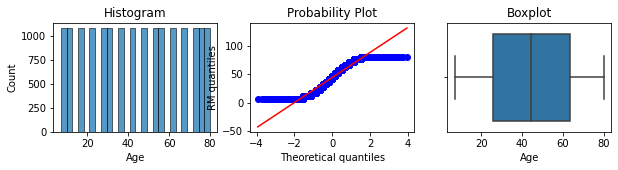

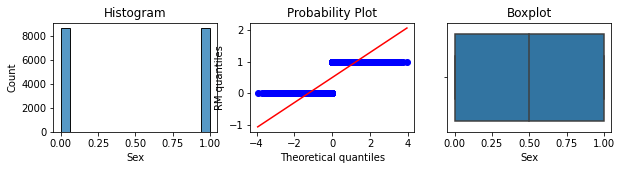

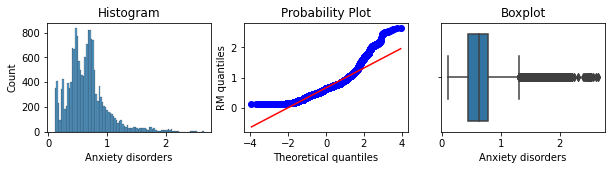

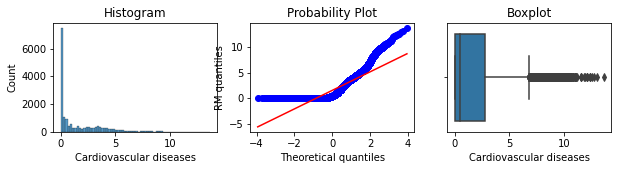

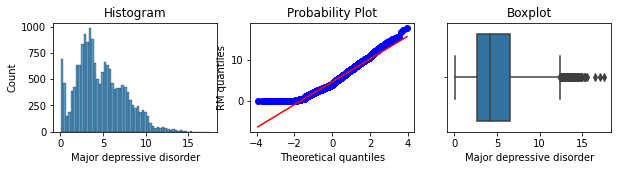

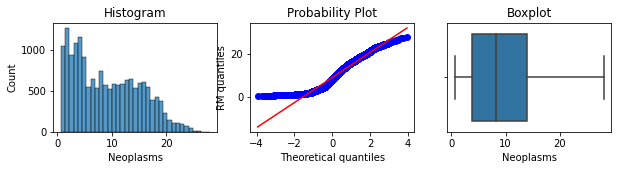

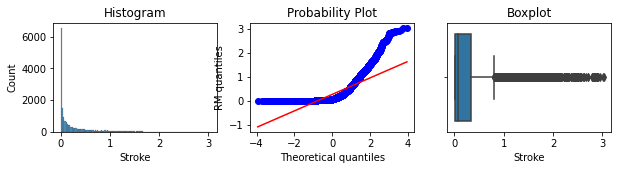

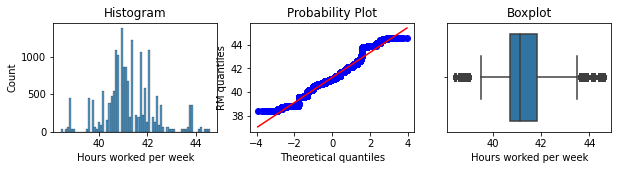

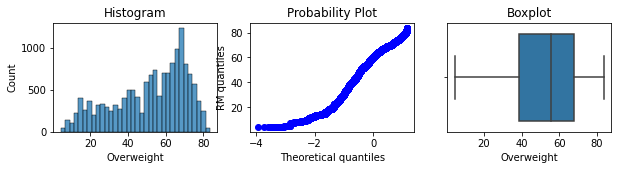

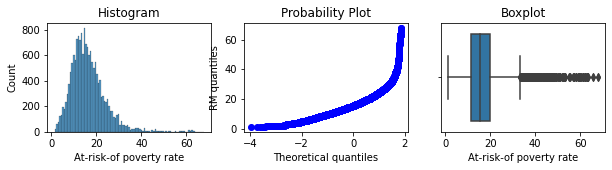

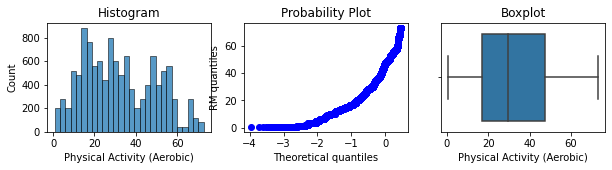

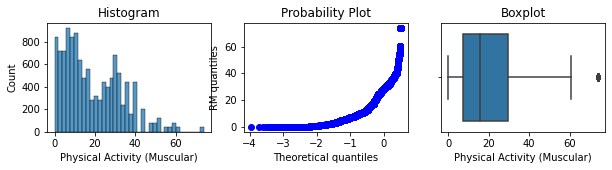

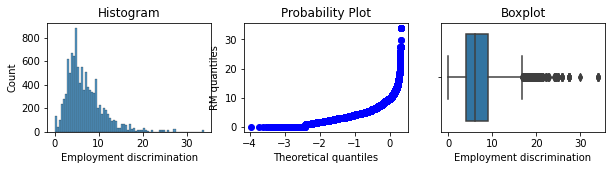

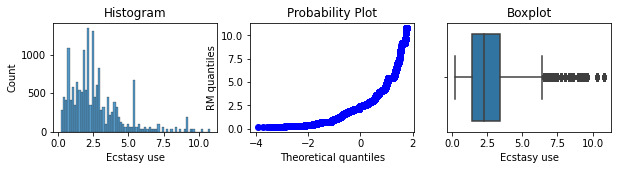

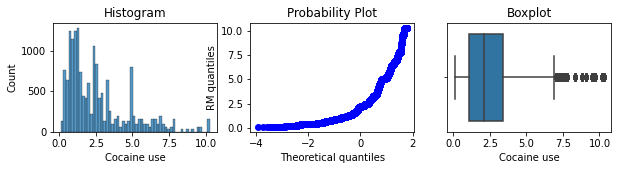

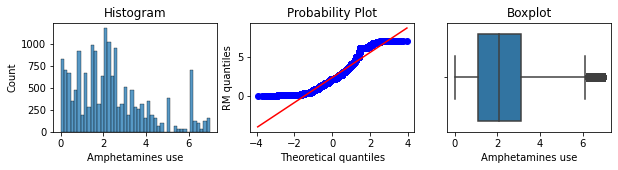

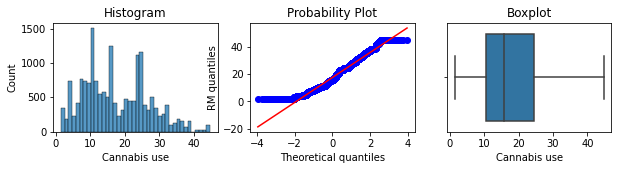

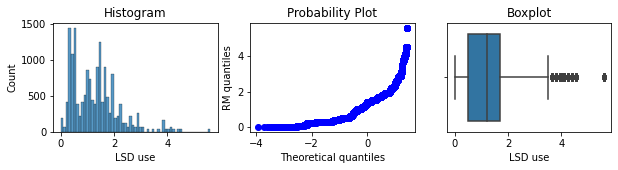

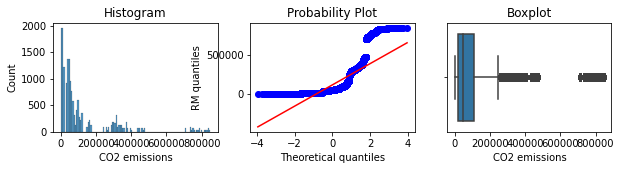

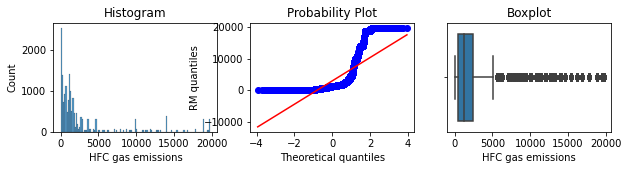

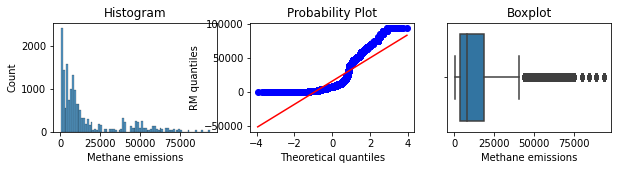

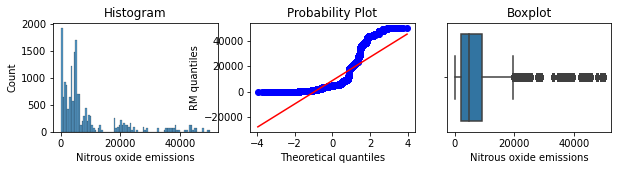

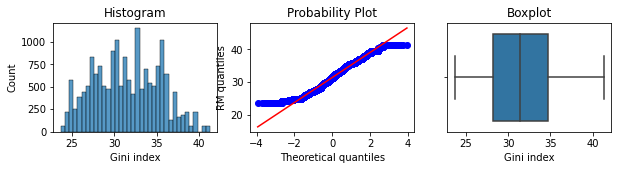

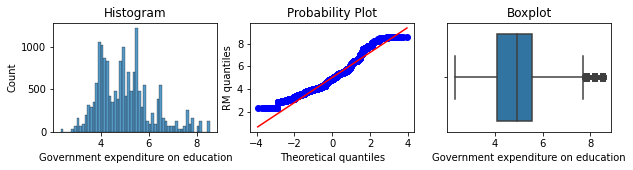

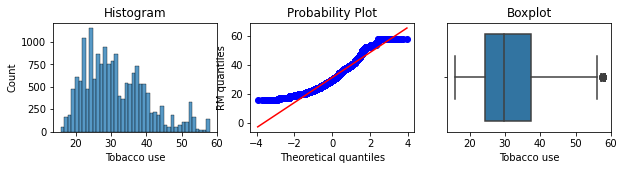

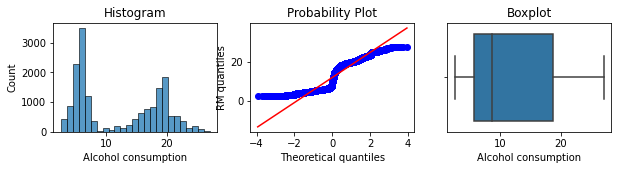

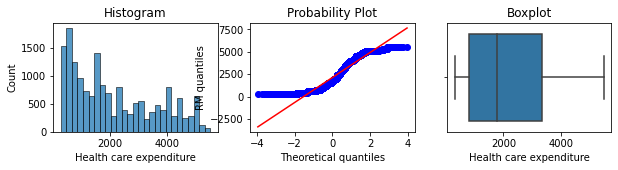

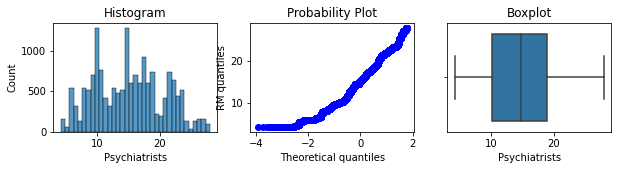

In [20]:
def analysis_outliers(df, variable):
    
    plt.figure(figsize=(10, 2))

    plt.subplot(1, 3, 1)
    sns.histplot(df[variable])
    plt.title('Histogram')
    
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    plt.subplot(1, 3, 3)
    sns.boxplot(x=df[variable])
    plt.title('Boxplot')
    
    plt.show()
    
    
for col in df_filled.drop(columns=['Year', 'Location']).columns.to_list():
        analysis_outliers(df_filled,col)

De este análisis exploratorio de los datos pueden llamarnos la atención algunos elementos de la distribución que, a simple vista podrían parecer outliers:

- `Population density` -> Debido a la elevada densidad de población de Malta, muy superior a la del resto de países miembros.

- `Noise` ->  Estonia presenta unos mayores niveles de ruido, pero siguen estando dentro de los baremos razonables, por lo que no puede considerarse como un valor atípico.

Podemos concluir, por tanto, que no existen valores atípicos con los que trabajar en la preparación de los datos.

### <a id="corr">2.5. Análisis de correlación</a>

In [21]:
df_filled.corr().round(2)

Age   Sex  \
Age                                                1.00  0.00   
Sex                                                0.00  1.00   
Anxiety disorders                                 -0.69 -0.31   
Cardiovascular diseases                            0.83  0.08   
Chronic respiratory diseases                       0.71  0.06   
Diabetes and kidney diseases                       0.84 -0.01   
Dysthymia                                          0.04 -0.31   
Major depressive disorder                          0.48 -0.53   
Neoplasms                                          0.82 -0.05   
Stroke                                             0.73  0.00   
Unemployment                                      -0.54  0.09   
Material deprivation                               0.03 -0.02   
Median income                                     -0.05  0.03   
Hours worked per week                             -0.00 -0.00   
Overweight                                         0.76  0.34   
Underweight                                       -0.53 -0.34   
At-risk-of poverty rate                           -0.06 -0.13   
Physical Activity (Aerobic)                       -0.43  0.21   
Physical Activity (Muscular)                      -0.46  0.16   
Employment discrimination                         -0.15 -0.10   
Ecstasy use                                       -0.00 -0.00   
Cocaine use                                       -0.00 -0.00   
Amphetamines use                                   0.00 -0.00   
Cannabis use                                       0.00 -0.00   
LSD use                                            0.00 -0.00   
CO2 emissions                                      0.00  0.00   
HFC gas emissions                                  0.00  0.00   
Methane emissions                                  0.00  0.00   
Nitrous oxide emissions                            0.00  0.00   
Compulsory education duration                      0.00  0.00   
Gini index                                         0.00  0.00   
Government expenditure on education                0.00 -0.00   
Tobacco use                                       -0.00  0.59   
Alcohol consumption                                0.00  0.94   
Educational attainment (at least upper secondary)  0.00  0.15   
Educational attainment (at least primary)          0.00  0.21   
Educational attainment (at least Bachelor)        -0.00 -0.09   
Population density                                -0.00  0.00   
Health care expenditure                            0.00  0.00   
Psychiatrists                                      0.00 -0.00   
Noise                                              0.00  0.00   

                                                   Anxiety disorders  \
Age                                                            -0.69   
Sex                                                            -0.31   
Anxiety disorders                                               1.00   
Cardiovascular diseases                                        -0.63   
Chronic respiratory diseases                                   -0.53   
Diabetes and kidney diseases                                   -0.58   
Dysthymia                                                       0.11   
Major depressive disorder                                      -0.11   
Neoplasms                                                      -0.53   
Stroke                                                         -0.58   
Unemployment                                                    0.27   
Material deprivation                                           -0.09   
Median income                                                   0.24   
Hours worked per week                                           0.04   
Overweight                                                     -0.60   
Underweight                                                     0.52   
At-risk-of poverty rate                                         0.01   
Physical Activity (Aerobi

In [24]:
correlations = df_filled.corr(method='pearson')
print(correlations['Dysthymia'].sort_values(ascending=False).to_string())

Dysthymia                                            1.000000
Major depressive disorder                            0.439173
Unemployment                                         0.334013
Material deprivation                                 0.313643
Underweight                                          0.291517
Anxiety disorders                                    0.113372
Age                                                  0.043239
Neoplasms                                            0.036271
Gini index                                           0.012191
Educational attainment (at least Bachelor)           0.010033
Amphetamines use                                     0.002011
Ecstasy use                                         -0.008434
Government expenditure on education                 -0.011235
Hours worked per week                               -0.011270
Educational attainment (at least upper secondary)   -0.014726
Physical Activity (Muscular)                        -0.015004
LSD use 

In [23]:
correlations = df_filled.corr(method='pearson')
print(correlations['Major depressive disorder'].sort_values(ascending=False).to_string())

Major depressive disorder                            1.000000
Age                                                  0.484240
Dysthymia                                            0.439173
Neoplasms                                            0.370593
Diabetes and kidney diseases                         0.290485
Cardiovascular diseases                              0.289913
Stroke                                               0.282397
Psychiatrists                                        0.137595
Educational attainment (at least Bachelor)           0.130485
Chronic respiratory diseases                         0.129932
Cocaine use                                          0.114880
Gini index                                           0.114628
Employment discrimination                            0.099136
At-risk-of poverty rate                              0.089515
Cannabis use                                         0.056693
Health care expenditure                              0.049244
Amphetam

In [22]:
correlations = df_filled.corr(method='pearson')
print(correlations['Anxiety disorders'].sort_values(ascending=False).to_string())

Anxiety disorders                                    1.000000
Underweight                                          0.517101
Unemployment                                         0.270224
Median income                                        0.238847
Health care expenditure                              0.207382
Employment discrimination                            0.170375
Physical Activity (Muscular)                         0.145643
HFC gas emissions                                    0.114099
Dysthymia                                            0.113372
Population density                                   0.105535
Compulsory education duration                        0.105346
Physical Activity (Aerobic)                          0.100217
Cocaine use                                          0.092854
Noise                                                0.087728
Government expenditure on education                  0.086279
Nitrous oxide emissions                              0.074406
CO2 emis

In [25]:
plt.figure(figsize=(15,12.5))

sns.heatmap(round(df_filled.corr(),1),annot=True,cmap='viridis_r',linewidth=0.9)
plt.show()

## <a id="vif">3. Selección de características (VIF: Factor de Inflación de la Varianza)</a>

La existencia de multicolinealidad (poder explicar una característica independiente mediante una combinación lineal del resto) en un modelo de regresión lineal o de clasificación suele ser problemático para el entrenamiento de los modelos. Una de las técnicas que se puede utilizar para identificar este problema es el VIF.

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Define target variables:
target = ['Anxiety disorders', 'Dysthymia', 'Major depressive disorder']

# Remove Location and Year
df_filled_i = df_filled.drop(columns = (['Location', 'Year'])).copy(deep = True)

# Simple imputer fo fill NaN values:
imputer = SimpleImputer(strategy = 'mean')

imputer.fit(df_filled_i)

df_filled_simp = pd.DataFrame(imputer.transform(df_filled_i))
df_filled_simp.columns = df_filled_i.columns
df_filled_simp.index = df_filled_i.index

def vif(df_arg):
   # Run VIF algorithm:
   df_vif = df_arg.copy(deep = True)
   features = list(df_vif.columns)

   vif_results = pd.DataFrame()
   vif_results['Feature'] = df_vif.columns
   vif_results['VIF'] = np.nan
   vif_results.set_index('Feature', inplace = True)

   for i in range(len(features)):
      var = features[i]
      fet = features[:]
      fet.remove(var)
      
      x = df_vif[fet]
      y = df_arg[var]
      
      model = LinearRegression()
      model.fit(x, y)
      
      vif_results.at[var, 'VIF'] = 1 / (1 - model.score(x, y))
      
   return vif_results.sort_values('VIF', ascending = False)

vif(df_filled_simp)


VIF
Feature                                                     
Methane emissions                                  40.375122
Nitrous oxide emissions                            34.862451
Age                                                33.948561
Sex                                                20.860622
CO2 emissions                                      19.136872
Alcohol consumption                                18.997807
Cardiovascular diseases                            17.399665
Stroke                                             12.163321
HFC gas emissions                                  11.836601
Cannabis use                                        8.187610
Diabetes and kidney diseases                        7.809991
Amphetamines use                                    7.642140
Cocaine use                                         7.246355
Overweight                                          7.171000
Physical Activity (Aerobic)                         6.808806
Physical Activity (Muscular)                        6.709323
Health care expenditure                             6.397704
Anxiety disorders                                   5.350890
Chronic respiratory diseases                        5.269990
Neoplasms                                           5.144029
Educational attainment (at least upper secondary)   4.938004
Dysthymia                                           4.786890
Major depressive disorder                           4.637020
Ecstasy use                                         4.374331
Median income                                       4.138330
Psychiatrists                                       3.687448
Educational attainment (at least primary)           3.399980
LSD use                                             3.164531
Tobacco use                                         3.158492
Gini index                                          3.153182
Hours worked per week                               2.904360
Government expenditure on education                 2.903629
Population density                                  2.840155
Underweight                                         2.757138
Material deprivation                                2.627059
Compulsory education duration                       2.347988
Educational attainment (at least Bachelor)          2.343402
Unemployment                                        2.017108
Noise                                               1.826335
At-risk-of poverty rate                             1.645438
Employment discrimination                           1.359246

En los resultados se puede observar que hay varias variables (`Methane emissions`, `CO2 emissions`, `Alcohol conssumption`, etc) con valor VIF por encima de 5. Se ha de eliminar la que tiene el valor más alto y volver a ejecutar el proceso. Solamente se ha de eliminar una característica en cada paso, ya que el problema puede encontrarse solamente en una.

In [27]:
def selectDataUsingVIF(data, target, max_VIF = 5):

    result = data.copy(deep = True).drop(columns = target)
        
    VIF = vif(result)

    while VIF.values[0] > max_VIF:
        features = list(VIF.index)
        print("Se eliminará la variable '", VIF.index[0], "' con un valor VIF de ", VIF.values[0])
        features.remove(str(VIF.index[0]))
        result = result[features]
        
        VIF = vif(result)
        
    return result

df_vif = selectDataUsingVIF(df_filled_simp, target)

Se eliminará la variable ' Methane emissions ' con un valor VIF de  [39.66761198]
Se eliminará la variable ' Alcohol consumption ' con un valor VIF de  [18.00905366]
Se eliminará la variable ' Cardiovascular diseases ' con un valor VIF de  [14.96544944]
Se eliminará la variable ' CO2 emissions ' con un valor VIF de  [14.95624529]
Se eliminará la variable ' Age ' con un valor VIF de  [10.67752378]
Se eliminará la variable ' HFC gas emissions ' con un valor VIF de  [8.41698115]
Se eliminará la variable ' Physical Activity (Aerobic) ' con un valor VIF de  [6.45367966]
Se eliminará la variable ' Cannabis use ' con un valor VIF de  [6.10604375]
Se eliminará la variable ' Health care expenditure ' con un valor VIF de  [5.04066355]


## <a id="ml">4. Creación de modelos de Machine Learning</a>

In [28]:
from sklearn.metrics import mean_absolute_error

def check_metrics(models):

    metrics = pd.DataFrame()

    metrics['Model'] = models.keys()

    metrics.set_index('Model', inplace = True)

    for k in models.keys():
        metrics.at[k, 'Training MAE'] = mean_absolute_error(y_train, models[k].predict(X_train))
        metrics.at[k, 'Test MAE'] = mean_absolute_error(y_test, models[k].predict(X_test))
        metrics.at[k, 'Test R2 score'] = models[k].score(X_test,y_test)
    
    return metrics

In [43]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {}

models['Ridge'] = Ridge()
models['Lasso'] = Lasso()
models['LinearRegression'] = LinearRegression()
models['SVR'] = SVR()
models['DecisionTreeRegressor'] = DecisionTreeRegressor()
models['RandomForestRegressor'] = RandomForestRegressor()
models['XGBRegressor'] = XGBRegressor()

### <a id="ml-dyst">4.1. Modelo para la variable `Dysthymia`</a>

#### <a id="ml-dyst-select">4.1.1. Selección de modelo</a>

In [65]:
from sklearn.model_selection import train_test_split

# Split data into feature matrix and target vector
y,X = df_filled_simp['Dysthymia'], df_vif

# split data into train / validation sets
X_train,X_test,y_train,y_test = train_test_split(X,y)

for k in models.keys(): models[k].fit(X_train,y_train)

check_metrics(models)

Training MAE  Test MAE  Test R2 score
Model                                                       
Ridge                      0.038372  0.038432       0.439720
Lasso                      0.053136  0.052263       0.002408
LinearRegression           0.038416  0.038449       0.440394
SVR                        0.050877  0.050416       0.184824
DecisionTreeRegressor      0.000000  0.004155       0.975069
RandomForestRegressor      0.001453  0.003938       0.989480
XGBRegressor               0.003501  0.005695       0.983067

#### <a id="ml-dyst-hyper">4.1.2. Optimización de hiperparámetros</a>

In [66]:
from sklearn.model_selection import RandomizedSearchCV

# Params for RandomSearch
params = {   'max_depth': np.arange(5, 101, 5),
             'n_estimators': np.arange(20, 201, 20),
             'max_features': ['sqrt', 'auto'],
             'min_samples_split': np.arange(2, 5, 1)}

# RandomSearch Model
estimator = RandomizedSearchCV(models['RandomForestRegressor'], params)

# Model fit
estimator.fit(X_train,y_train)

print(f"Best hyper-params: {estimator.best_params_}\nBest accuracy: {estimator.best_score_}")

Best hyper-params: {'n_estimators': 180, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': 75}
Best accuracy: 0.9855697088492956


In [67]:
print("Train R2 score with no optimization: ", models['RandomForestRegressor'].score(X_train, y_train))
print("Train R2 score after optimization: ", estimator.score(X_train,y_train))
print("Test R2 score with no optimization: ", models['RandomForestRegressor'].score(X_test, y_test))
print("Test R2 score after optimization: ", estimator.score(X_test,y_test))

Train R2 score with no optimization:  0.9984294284721988
Train R2 score after optimization:  0.9982278493453199
Test R2 score with no optimization:  0.9894800067646693
Test R2 score after optimization:  0.9889277990601527


#### <a id="ml-dyst-viz">4.1.3. Visualización de modelo</a>

In [68]:
# Shap force plot also showing feature importance
import shap

explainer = shap.TreeExplainer(models['RandomForestRegressor'], X_train.head(100))
shap_values = explainer(X_train.head(100))
f = plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="bar")
f.savefig("Dysthymia_varImportancePlot.png", bbox_inches='tight', dpi=600)

 92%|==================  | 92/100 [00:11<00:00]       

In [69]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_train.head(100))
f.savefig("Dysthymia_PosNegRelationshipsPlot.png", bbox_inches='tight', dpi=600)

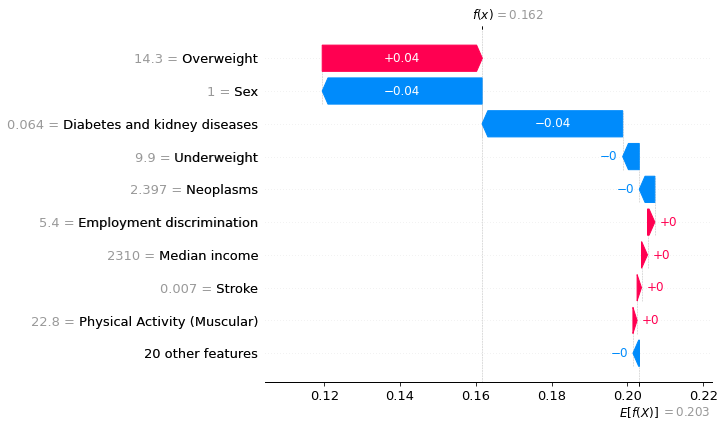

In [70]:
f = plt.figure()
shap.plots.waterfall(shap_values[0])
f.savefig("Dysthymia_WaterfallPlot.png", bbox_inches='tight', dpi=600)

In [71]:
explainer = shap.TreeExplainer(models['RandomForestRegressor'])
shap_values = explainer.shap_values(X_train.head(1))

shap.initjs()
shap.force_plot(explainer.expected_value,
                shap_values = shap_values,
                features = X_train.head(1),)

### <a id="ml-depr">4.2. Modelo para la variable `Major Depressive Disorder`</a>

#### <a id="ml-depr-select">4.2.1. Selección de modelo</a>

In [72]:
y = df_filled_simp['Major depressive disorder']

# split data into train / validation sets
X_train,X_test,y_train,y_test = train_test_split(X,y)

for k in models.keys(): models[k].fit(X_train,y_train)

check_metrics(models)

Training MAE  Test MAE  Test R2 score
Model                                                       
Ridge                      1.332505  1.365833       0.591466
Lasso                      1.755170  1.778456       0.356864
LinearRegression           1.332485  1.365737       0.591489
SVR                        2.127142  2.150037       0.042036
DecisionTreeRegressor      0.000000  0.155955       0.984933
RandomForestRegressor      0.045287  0.120819       0.994292
XGBRegressor               0.115267  0.185612       0.990819

#### <a id="ml-depr-hyper">4.2.2. Optimización de hiperparámetros</a>

In [73]:
# RandomSearch Model
estimator = RandomizedSearchCV(models['RandomForestRegressor'], params)

# Model fit
estimator.fit(X_train,y_train)

print(f"Best hyper-params: {estimator.best_params_}\nBest accuracy: {estimator.best_score_}")

Best hyper-params: {'n_estimators': 200, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': 35}
Best accuracy: 0.9929946324816891


In [74]:
print("Train R2 score with no optimization: ", models['RandomForestRegressor'].score(X_train, y_train))
print("Train R2 score after optimization: ", estimator.score(X_train,y_train))
print("Test R2 score with no optimization: ", models['RandomForestRegressor'].score(X_test, y_test))
print("Test R2 score after optimization: ", estimator.score(X_test,y_test))

Train R2 score with no optimization:  0.9992285449983557
Train R2 score after optimization:  0.9991930993752164
Test R2 score with no optimization:  0.9942919574673785
Test R2 score after optimization:  0.9940349270181206


#### <a id="ml-depr-viz">4.2.3. Visualización de modelo</a>

 95%|=================== | 95/100 [00:12<00:00]       

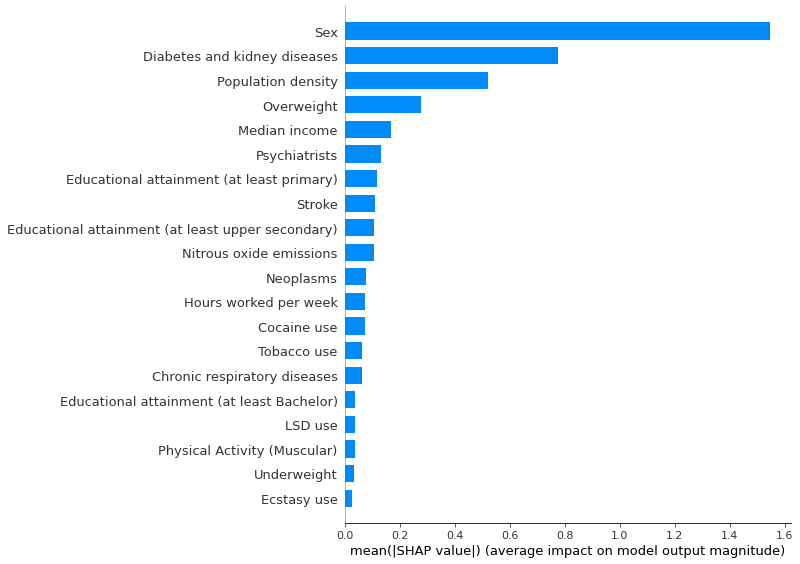

In [75]:
explainer = shap.TreeExplainer(models['RandomForestRegressor'], X_train.head(100))
shap_values = explainer(X_train.head(100))

f = plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="bar")
f.savefig("Depression_varImportancePlot.png", bbox_inches='tight', dpi=600)


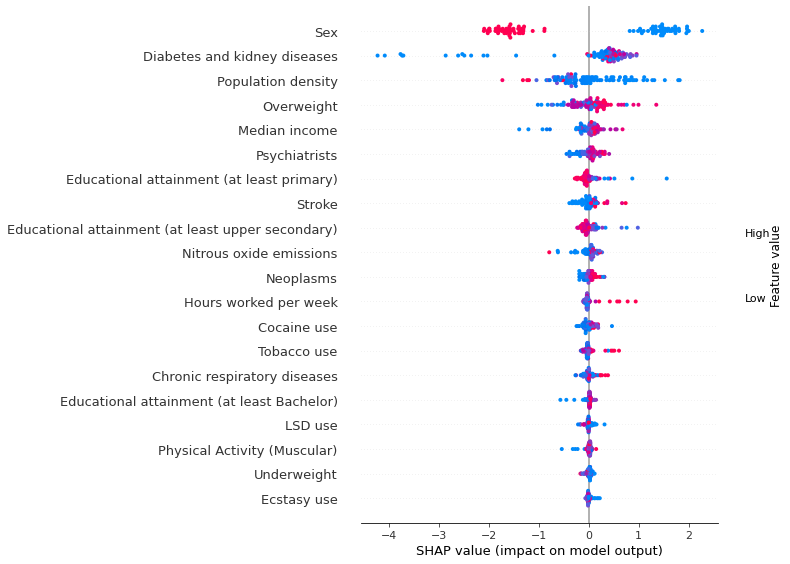

In [76]:
f = plt.figure()
shap.summary_plot(shap_values, X_train.head(100))
f.savefig("Depression_PosNegRelationshipsPlot.png", bbox_inches='tight', dpi=600)

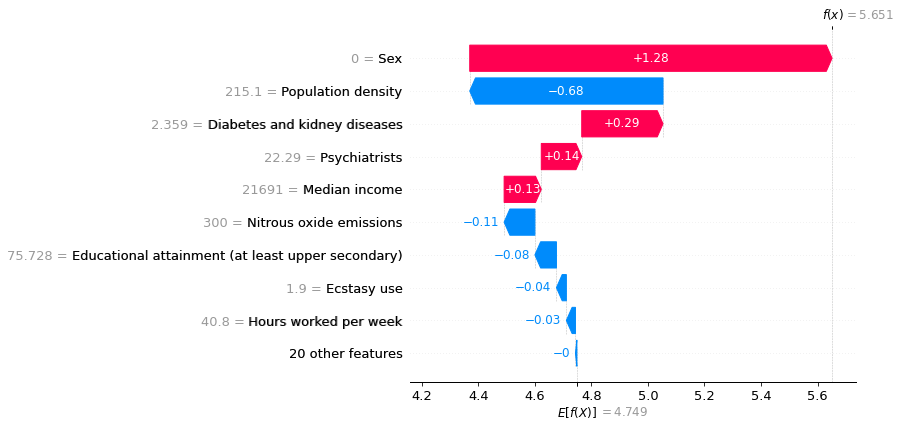

In [77]:
f = plt.figure()
shap.plots.waterfall(shap_values[0])
f.savefig("Depression_WaterfallPlot.png", bbox_inches='tight', dpi=600)

In [79]:
explainer = shap.TreeExplainer(models['RandomForestRegressor'])
shap_values = explainer.shap_values(X_train.head(1))
shap.initjs()
shap.force_plot(explainer.expected_value,
                shap_values = shap_values,
                features = X_train.head(1))

### <a id="ml-anxi">4.3. Modelo para la variable `Anxiety Disorders`</a>

#### <a id="ml-anxi-select">4.3.1. Selección de modelo</a>

In [80]:
y = df_filled_simp['Anxiety disorders']

# split data into train / validation sets
X_train,X_test,y_train,y_test = train_test_split(X,y)

for k in models.keys(): models[k].fit(X_train,y_train)

check_metrics(models)

Training MAE  Test MAE  Test R2 score
Model                                                       
Ridge                      0.134482  0.133989       0.695484
Lasso                      0.208136  0.212158       0.197196
LinearRegression           0.134548  0.134037       0.695580
SVR                        0.232089  0.235993       0.054743
DecisionTreeRegressor      0.000000  0.019487       0.982779
RandomForestRegressor      0.005758  0.015159       0.993665
XGBRegressor               0.014721  0.023050       0.990481

#### <a id="ml-anxi-hyper">4.3.2. Optimización de hiperparámetros</a>

In [81]:
# RandomSearch Model
estimator = RandomizedSearchCV(models['RandomForestRegressor'], params)

# Model fit
estimator.fit(X_train,y_train)

print(f"Best hyper-params: {estimator.best_params_}\nBest accuracy: {estimator.best_score_}")

Best hyper-params: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 95}
Best accuracy: 0.9916993077216197


In [82]:
print("Train R2 score with no optimization: ", models['RandomForestRegressor'].score(X_train, y_train))
print("Train R2 score after optimization: ", estimator.score(X_train,y_train))
print("Test R2 score with no optimization: ", models['RandomForestRegressor'].score(X_test, y_test))
print("Test R2 score after optimization: ", estimator.score(X_test,y_test))

Train R2 score with no optimization:  0.9991169625942012
Train R2 score after optimization:  0.9991391702194177
Test R2 score with no optimization:  0.9936650693796909
Test R2 score after optimization:  0.9937690751496961


#### <a id="ml-anxi-viz">4.3.3. Visualización de modelo</a>

 99%|===================| 99/100 [00:13<00:00]        

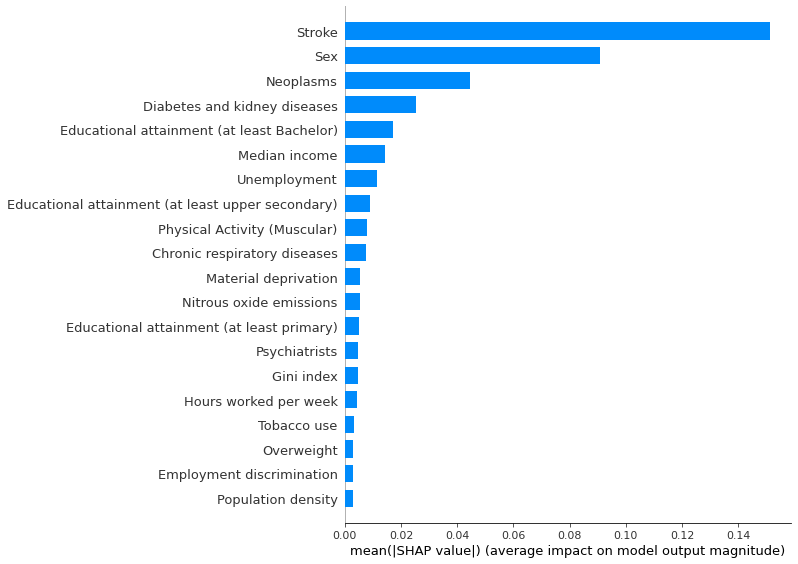

In [88]:
explainer = shap.TreeExplainer(models['RandomForestRegressor'], X_train.head(100))
shap_values = explainer(X_train.head(100))

f = plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="bar")
f.savefig("Anxiety_varImportancePlot.png", bbox_inches='tight', dpi=600)

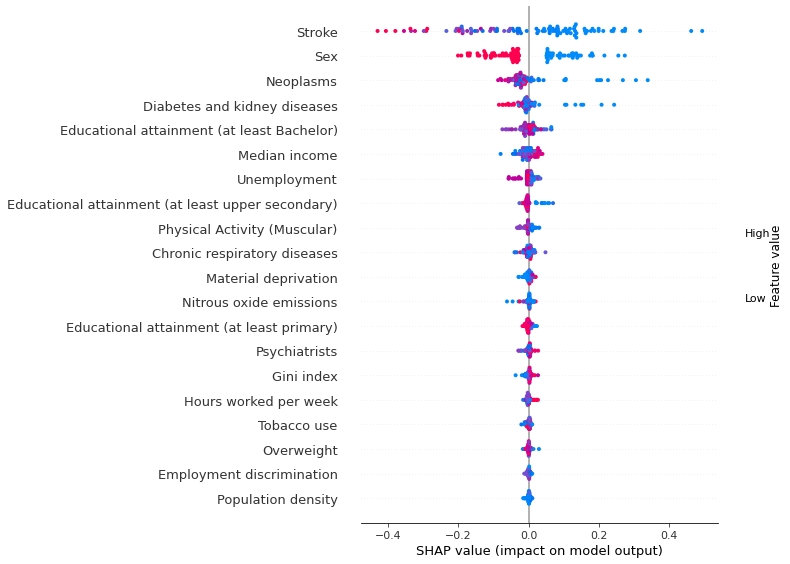

In [89]:
f = plt.figure()
shap.summary_plot(shap_values, X_train.head(100))
f.savefig("Anxiety_PosNegRelationshipsPlot.png", bbox_inches='tight', dpi=600)

In [90]:
f = plt.figure()
shap.plots.waterfall(shap_values[0])
f.savefig("Anxiety_WaterfallPlot.png", bbox_inches='tight', dpi=600)

In [91]:
explainer = shap.TreeExplainer(models['RandomForestRegressor'])
shap_values = explainer.shap_values(X_train.head(1))
shap.initjs()
shap.force_plot(explainer.expected_value,
                shap_values = shap_values,
                features = X_train.head(1))